# Data Acquisition

### Import librerie utili sezione

In [1]:
import pandas as pd
import os 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pickle
import numpy as np

# Preprocessing

In [2]:
file_path = "../../train.csv"
df = pd.read_csv(file_path)

In [3]:
clean_df = df.dropna() 
clean_df = df.drop_duplicates()

In [4]:
# Itera su ogni anno presente nel DataFrame
for year in clean_df['Year'].unique():
    # Filtra il DataFrame per l'anno corrente
    df_year = clean_df[clean_df['Year'] == year]
    
    # Calcola la mediana per ogni colonna
    median_values = df_year.median()
    
    # Calcola i limiti per individuare gli outlier per ogni colonna
    Q1 = df_year.quantile(0.25)
    Q3 = df_year.quantile(0.75)
    IQR = Q3 - Q1
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR
    
    # Sostituisci gli outlier con la mediana per ogni colonna
    def replace_outliers(row):
        for col in df_year.columns[1:]:  # Escludi la colonna 'year'
            if row[col] < lower_limit[col] or row[col] > upper_limit[col]:
                row[col] = median_values[col]
        return row
    
    df_year = df_year.apply(replace_outliers, axis=1) # Sostituzione outlier con mediana
    
    # Sostituisci i dati nel DataFrame originale
    clean_df.loc[clean_df['Year'] == year] = df_year

In [6]:
# Seleziona solo le colonne che iniziano con 'S'
colonne_s = [col for col in clean_df.columns if col.startswith('S')]

# Lista per memorizzare i risultati originali e nuovi
risultati_outliers = []
risultati_nuovi_outliers = []

# Ciclo attraverso ogni colonna 'S'
for col in colonne_s:
    # Calcola i quantili e l'IQR (Interquartile Range) per i dati originali
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    
    # Calcola i baffi inferiori e superiori
    baffo_inferiore = q1 - 1.5 * iqr
    baffo_superiore = q3 + 1.5 * iqr
    
    # Trova gli outliers inferiori e superiori per i dati originali
    outliers_inferiori = df[df[col] < baffo_inferiore]
    outliers_superiori = df[df[col] > baffo_superiore]
    numero_outliers = len(outliers_inferiori) + len(outliers_superiori)
    
    # Calcola la percentuale di outliers
    percentuale_outliers = (numero_outliers / len(df)) * 100
    
    # Aggiungi i risultati alla lista
    risultati_outliers.append({
        'Colonna': col,
        'Numero outliers': numero_outliers,
        'Percentuale outliers': f'{percentuale_outliers:.2f}%'
    })
    
    # Calcola i quantili e l'IQR (Interquartile Range) per i dati modificati
    q1_new = clean_df[col].quantile(0.25)
    q3_new = clean_df[col].quantile(0.75)
    iqr_new = q3_new - q1_new
    
    # Calcola i baffi inferiori e superiori per i dati modificati
    baffo_inferiore_new = q1_new - 1.5 * iqr_new
    baffo_superiore_new = q3_new + 1.5 * iqr_new
    
    # Trova gli outliers inferiori e superiori per i dati modificati
    outliers_inferiori_new = clean_df[clean_df[col] < baffo_inferiore_new]
    outliers_superiori_new = clean_df[clean_df[col] > baffo_superiore_new]
    numero_outliers_new = len(outliers_inferiori_new) + len(outliers_superiori_new)
    
    # Calcola la percentuale di nuovi outliers
    percentuale_outliers_new = (numero_outliers_new / len(clean_df)) * 100
    
    # Aggiungi i risultati alla lista dei nuovi outliers
    risultati_nuovi_outliers.append({
        'Colonna': col,
        'Numero nuovi outliers': numero_outliers_new,
        'Percentuale nuovi outliers': f'{percentuale_outliers_new:.2f}%'
    })

# Converti le liste in DataFrame
df_outliers = pd.DataFrame(risultati_outliers)
df_nuovi_outliers = pd.DataFrame(risultati_nuovi_outliers)

# Unisci i DataFrame sui risultati originali e nuovi
outliers_summary_df = df_outliers.merge(df_nuovi_outliers, on='Colonna')

# Visualizza la tabella finale
print(outliers_summary_df)


   Colonna  Numero Outliers Percentuale Outliers  Numero nuovo Outliers  \
0       S0             5306                2.10%                   1492   
1       S1             7313                2.90%                   2684   
2       S2             7484                2.97%                   2657   
3       S3            11229                4.45%                   4782   
4       S4             5224                2.07%                   1429   
..     ...              ...                  ...                    ...   
85     S85            16608                6.59%                   8073   
86     S86            15876                6.30%                   7731   
87     S87            14794                5.87%                   7548   
88     S88            19031                7.55%                   9973   
89     S89            19330                7.67%                  10960   

   Percentuale nuova Outliers  
0                       0.59%  
1                       1.06%  
2  

In [7]:
X = clean_df.drop(columns=['Year']) 
y = clean_df['Year'] 

# TabTransformer

In [26]:
import pandas as pd
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import mean_squared_error

from pytorch_tabular import TabularModel
from pytorch_tabular.models import TabTransformerConfig
from pytorch_tabular.config import (
    DataConfig,
    OptimizerConfig,
    TrainerConfig,
)
import torch
from itertools import product
import matplotlib.pyplot as plt
import seaborn as sns



### Divisione dataset in training e validation set

In [27]:
train, val = train_test_split(clean_df, random_state=42, test_size=0.2)

### Funzione di addestramento e valutazione

In [28]:
def train_and_evaluate_tabtransformer(train, val, max_epochs, batch_size):
    # Configurazione dei dati per il modello
    data_config = DataConfig(
        target=["Year"],  # Variabile target da predire 
        continuous_cols=X.columns.tolist(),  # Input per il modello
    )

    # Configurazione del modello
    model_config = TabTransformerConfig(
        task="regression",
        metrics=['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', 'r2_score'],
    )

    # Configurazione dell'ottimizzatore e del trainer
    optimizer_config = OptimizerConfig()
    trainer_config = TrainerConfig(
        batch_size=batch_size,
        auto_lr_find=False,
        max_epochs=max_epochs,
        early_stopping_patience=10,
        #accelerator="gpu"
        accelerator="cpu", # Usiamo CPU perché la GPU non è compatibile
    )

    # Modello per TabTransformer
    tabular_model = TabularModel(
        data_config=data_config,
        model_config=model_config,
        optimizer_config=optimizer_config,
        trainer_config=trainer_config,
    )

    tabular_model.fit(train=train, validation=val)

    val_pred = tabular_model.predict(val)
    mse = mean_squared_error(val["Year"], val_pred)
    
    return mse

### Definizione Grid Search

In [29]:
param_grid = {
    'batch_size': [128],  
    'max_epochs': [100] 
}

### Grid Search per ricerca iperparametri

In [30]:
best_params = None
best_score = float('inf')

for params in ParameterGrid(param_grid):
    score = train_and_evaluate_tabtransformer(
        train,
        val,
        max_epochs=params["max_epochs"],
        batch_size=params["batch_size"]
    )
    if score < best_score:
        best_score = score
        best_params = params

print("Migliori Parametri:", best_params)
print("Miglior Score:", best_score)

2024-09-02 16:36:18,651 - {pytorch_tabular.tabular_model:140} - INFO - Experiment Tracking is turned off

Seed set to 42


2024-09-02 16:36:19,336 - {pytorch_tabular.tabular_model:524} - INFO - Preparing the DataLoaders

2024-09-02 16:36:22,205 - {pytorch_tabular.tabular_datamodule:499} - INFO - Setting up the datamodule for          
regression task

2024-09-02 16:36:28,447 - {pytorch_tabular.tabular_model:574} - INFO - Preparing the Model: TabTransformerModel

2024-09-02 16:36:29,454 - {pytorch_tabular.tabular_model:340} - INFO - Preparing the Trainer

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


2024-09-02 16:36:30,463 - {pytorch_tabular.tabular_model:652} - INFO - Training Started

/Users/martinazauli/Library/Python/3.9/lib/python/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:639: Checkpoint directory /Users/martinazauli/Desktop/Project_DataAnalytics/TrainingModule/saved_models exists and is not empty.


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name             ┃ Type                   ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ _backbone        │ TabTransformerBackbone │  271 K │
│ 1 │ _embedding_layer │ Embedding2dLayer       │      0 │
│ 2 │ _head            │ LinearHead             │     91 │
│ 3 │ loss             │ MSELoss                │      0 │
└───┴──────────────────┴────────────────────────┴────────┘

Trainable params: 271 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 271 K                                                                                                
Total estimated model params size (MB): 1

Output()

/Users/martinazauli/Library/Python/3.9/lib/python/site-packages/pytorch_lightning/trainer/connectors/data_connector
.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value 
of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.

/Users/martinazauli/Library/Python/3.9/lib/python/site-packages/pytorch_lightning/trainer/connectors/data_connector
.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value
of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.

2024-09-02 19:10:55,950 - {pytorch_tabular.tabular_model:663} - INFO - Training the model completed

2024-09-02 19:10:56,547 - {pytorch_tabular.tabular_model:1489} - INFO - Loading the best model

Migliori Parametri: {'batch_size': 128, 'max_epochs': 100}
Miglior Score: 79.17603057206712


In [31]:
best_model_config = TabTransformerConfig(
    task="regression",
    metrics=['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', 'r2_score'],
)

trainer_config = TrainerConfig(
    batch_size=best_params["batch_size"],
    auto_lr_find=False,
    max_epochs=best_params["max_epochs"],
    early_stopping_patience=10,
    #accelerator="gpu"
    accelerator="cpu", # Usiamo CPU perché la GPU non è compatibile
)

tabular_model = TabularModel(
    data_config=DataConfig(
        target=["Year"],
        continuous_cols=X.columns.tolist(),
    ),
    model_config=best_model_config,
    optimizer_config=OptimizerConfig(),
    trainer_config=trainer_config,
)

tabular_model.fit(train=clean_df)

# Salvataggio del modello
torch.save(tabular_model, open("tabTransf_best.save", 'wb'))

2024-09-02 19:11:18,739 - {pytorch_tabular.tabular_model:140} - INFO - Experiment Tracking is turned off

Seed set to 42


2024-09-02 19:11:19,412 - {pytorch_tabular.tabular_model:524} - INFO - Preparing the DataLoaders

2024-09-02 19:11:28,652 - {pytorch_tabular.tabular_datamodule:499} - INFO - Setting up the datamodule for          
regression task

2024-09-02 19:11:36,102 - {pytorch_tabular.tabular_model:574} - INFO - Preparing the Model: TabTransformerModel

2024-09-02 19:11:36,810 - {pytorch_tabular.tabular_model:340} - INFO - Preparing the Trainer

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


2024-09-02 19:11:37,703 - {pytorch_tabular.tabular_model:652} - INFO - Training Started

/Users/martinazauli/Library/Python/3.9/lib/python/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:639: Checkpoint directory /Users/martinazauli/Desktop/Project_DataAnalytics/TrainingModule/saved_models exists and is not empty.


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name             ┃ Type                   ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ _backbone        │ TabTransformerBackbone │  271 K │
│ 1 │ _embedding_layer │ Embedding2dLayer       │      0 │
│ 2 │ _head            │ LinearHead             │     91 │
│ 3 │ loss             │ MSELoss                │      0 │
└───┴──────────────────┴────────────────────────┴────────┘

Trainable params: 271 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 271 K                                                                                                
Total estimated model params size (MB): 1

Output()

/Users/martinazauli/Library/Python/3.9/lib/python/site-packages/pytorch_lightning/trainer/connectors/data_connector
.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value 
of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.

/Users/martinazauli/Library/Python/3.9/lib/python/site-packages/pytorch_lightning/trainer/connectors/data_connector
.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value
of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.

2024-09-02 22:18:49,720 - {pytorch_tabular.tabular_model:663} - INFO - Training the model completed

2024-09-02 22:18:49,753 - {pytorch_tabular.tabular_model:1489} - INFO - Loading the best model

Output()

/Users/martinazauli/Library/Python/3.9/lib/python/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃             Test metric             ┃            DataLoader 0             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│              test_loss              │          79.19596099853516          │
│      test_mean_absolute_error       │         6.5241169929504395          │
│ test_mean_absolute_percentage_error │        0.0032740216702222824        │
│       test_mean_squared_error       │          79.19596099853516          │
│            test_r2_score            │         0.2634124457836151          │
└─────────────────────────────────────┴─────────────────────────────────────┘

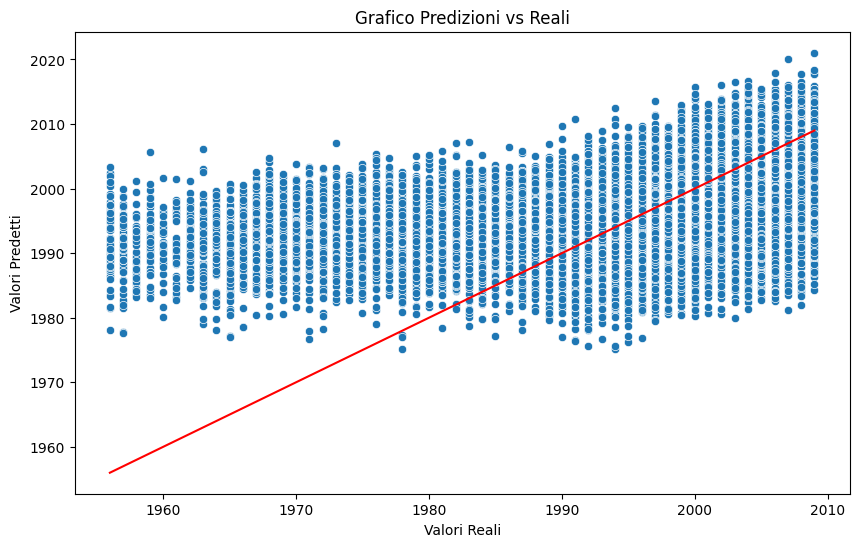

In [32]:
val_pred = tabular_model.predict(val)
result = tabular_model.evaluate(val)


result_df = val.copy()
result_df['Predict_Year'] = val_pred

plt.figure(figsize=(10, 6))
sns.scatterplot(x='Year', y='Predict_Year', data=result_df)
plt.plot([result_df['Year'].min(), result_df['Year'].max()],
         [result_df['Year'].min(), result_df['Year'].max()],
         color='red', linestyle='-')
plt.xlabel('Valori Reali')
plt.ylabel('Valori Predetti')
plt.title('Grafico Predizioni vs Reali')
plt.show()